In [32]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import tqdm
%matplotlib inline
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from IPython.display import HTML
from base64 import b64encode
from tensorflow.keras.layers import Input,Dense, Flatten, ReLU, Conv2D, DepthwiseConv2D,AvgPool2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from typing import Optional
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')



In [33]:
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 30

In [34]:
CLASSES_LIST = ["E03(Lateral_Rotation)"]

In [35]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [36]:
def create_dataset(video_dir, csv_file_path):
    features = []
    labels = []
    video_files_paths = []
    matching_files_count = 0

    # Read the CSV file
    csv_data = pd.read_csv(csv_file_path)

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(video_dir, class_name))

        for file_name in files_list:
            # Remove the .mp4 extension from the file name
            video_name = os.path.splitext(file_name)[0]

            video_file_path = os.path.join(video_dir, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                # Search for the exercise name in the CSV data that matches with video file name
                matching_row = csv_data[csv_data['Excercise Name'].str.lower() == video_name.lower()]

                if not matching_row.empty:
                    assessment_score = matching_row['Assessment Score'].values[0]
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
                    matching_files_count += 1
                    print(f'Matched file: {video_name}, Assessment Score: {assessment_score}')
                else:
                    # Append None if no matching row is found
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
                    print(f'No matching row found for file: {video_name}')

    features = np.asarray(features)
    labels = np.asarray(labels)

    print(f'Total matching files: {matching_files_count}')

    return features, labels, matching_files_count, video_files_paths


In [37]:
import pandas as pd

video_dir = '/kaggle/input/e01-e03-80/E03/E03'
csv_file_path = '/kaggle/input/csv-files-regression/Ex_03_sub.csv'
features, labels, matching_files_count, video_files_paths =  create_dataset(video_dir, csv_file_path)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("Matching files count:", matching_files_count)
print("Number of video files:", len(video_files_paths))

Extracting Data of Class: E03(Lateral_Rotation)
Matched file: E03_P33_AF_VHJ_GM, Assessment Score: 53.81
Matched file: E03_P18_AR_VHJ_GM, Assessment Score: 68.1
Matched file: E03_P18_AR_VLJ_GM, Assessment Score: 70.48
Matched file: E03_P21_AL_VO_GM, Assessment Score: 71.43
Matched file: E03_P20_AF_VML_GM, Assessment Score: 76.67
Matched file: E03_P26_AF_VFL_GF, Assessment Score: 52.38
Matched file: E03_P16_AF_VHJ_GF, Assessment Score: 95.24
Matched file: E03_P19_AF_VHJ_GM, Assessment Score: 72.38
Matched file: E03_P20_AF_VFL_GM, Assessment Score: 77.14
Matched file: E03_P20_AR_VO_GM, Assessment Score: 74.29
Matched file: E03_P10_AF_VLL_GF, Assessment Score: 81.43
Matched file: E03_P18_AR_VO_GM, Assessment Score: 73.81
Matched file: E03_P03_AR_VO_GM, Assessment Score: 97.62
Matched file: E03_P08_AF_VO_GM, Assessment Score: 80.0
Matched file: E03_P06_AR_VLJ_GM, Assessment Score: 100.0
Matched file: E03_P32_AF_VLL_GM, Assessment Score: 23.81
Matched file: E03_P02_AF_VLL_GM, Assessment Sco

In [38]:
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

In [39]:
features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

In [40]:
print(f'Number of features: {len(features)}, Number of labels: {len(labels)}, Number of video_files_paths: {len(video_files_paths)}')

Number of features: 80, Number of labels: 80, Number of video_files_paths: 80


In [41]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.20, shuffle=True, random_state=42
)

print(f"Training features: {features_train.shape}, Training labels: {labels_train.shape}")
print(f"Testing features: {features_test.shape}, Testing labels: {labels_test.shape}")


Training features: (64, 30, 128, 128, 3), Training labels: (64,)
Testing features: (16, 30, 128, 128, 3), Testing labels: (16,)


In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# Define custom metrics: RMSE and MAD
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def mad(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    return tf.reduce_mean(tf.abs(y_pred - tf.reduce_mean(y_pred)))

# Define the 3D CNN model
def create_3d_cnn_model(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH):
    """
    A 3D CNN model for spatiotemporal feature extraction and regression.
    """
    # Define the video input (4D input for 3D CNN)
    video_input = layers.Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    
    # 3D CNN layers for spatiotemporal feature extraction
    x = layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu')(video_input)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(128, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)

    # Flatten the output of the 3D CNN
    x = layers.GlobalAveragePooling3D()(x)

    # Dense layer for regression output
    regression_output = layers.Dense(1, activation='sigmoid', name='regression_output')(x)
    
    # Build the model
    model = models.Model(inputs=video_input, outputs=[regression_output])
    model.summary()
    
    return model


In [59]:
# Define hyperparameters
SEQUENCE_LENGTH = 30  # Set according to your input data
IMAGE_HEIGHT = 128  # Set the height of your input images
IMAGE_WIDTH = 128  # Set the width of your input images

# Create the model
model = create_3d_cnn_model(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 30, 128, 128,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 15, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 15, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 7, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 32, 32, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 7, 32, 32, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 3, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 16, 16, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_output (Dense)       │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,321 (1.07 MB)

 Trainable params: 279,873 (1.07 MB)

 Non-trainable params: 448 (1.75 KB)

In [60]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mean_squared_error',  # Use MSE for regression
              metrics=['mean_absolute_error', rmse, mad])

# Define Early Stopping and Learning Rate Scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.5 if epoch % 10 == 0 and epoch > 0 else lr, verbose=1)



# Callbacks list
callbacks = [early_stopping, lr_scheduler]
# Train the model
history = model.fit(features_train, labels_train,
                    validation_data=(features_test, labels_test),
                    epochs=60, batch_size=8, verbose=1, 
                    callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 137s 17s/step - loss: 0.2509 - mad: 0.0266 - mean_absolute_error: 0.4992 - rmse: 0.5009 - val_loss: 0.2538 - val_mad: 0.0015 - val_mean_absolute_error: 0.5038 - val_rmse: 0.5038 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 133s 17s/step - loss: 0.2467 - mad: 0.0157 - mean_absolute_error: 0.4962 - rmse: 0.4967 - val_loss: 0.2746 - val_mad: 0.0027 - val_mean_absolute_error: 0.5240 - val_rmse: 0.5240 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 17s/step - loss: 0.2435 - mad: 0.0142 - mean_absolute_error: 0.4931 - rmse: 0.4934 - val_loss: 0.2743 - val_mad: 0.0061 - val_mean_absolute_error: 0.5236 - val_rmse: 0.5237 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler se

In [61]:
# Evaluate the model on the test data
evaluation = model.evaluate(features_test, labels_test)

# Print the evaluation results with four decimal places
print(f"Evaluation Loss (MSE): {evaluation[0]:.5f}")
print(f"Evaluation MAE: {evaluation[1]:.5f}")
print(f"Evaluation RMSE: {evaluation[2]:.5f}")
print(f"Evaluation MAD: {evaluation[3]:.5f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2075 - mad: 0.0075 - mean_absolute_error: 0.4555 - rmse: 0.4556
Evaluation Loss (MSE): 0.20753
Evaluation MAE: 0.45546
Evaluation RMSE: 0.45555
Evaluation MAD: 0.00754


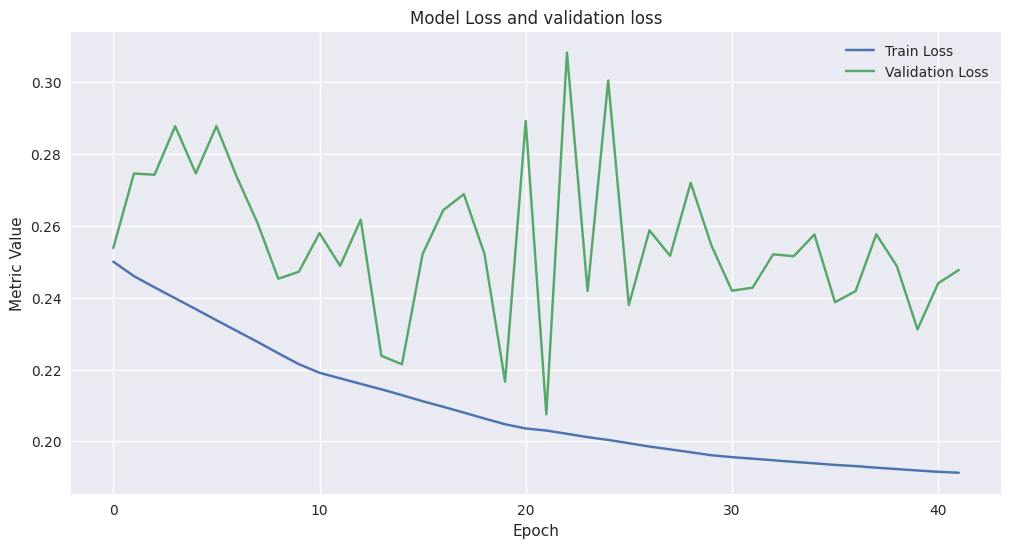

In [62]:
# Plot the Train loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

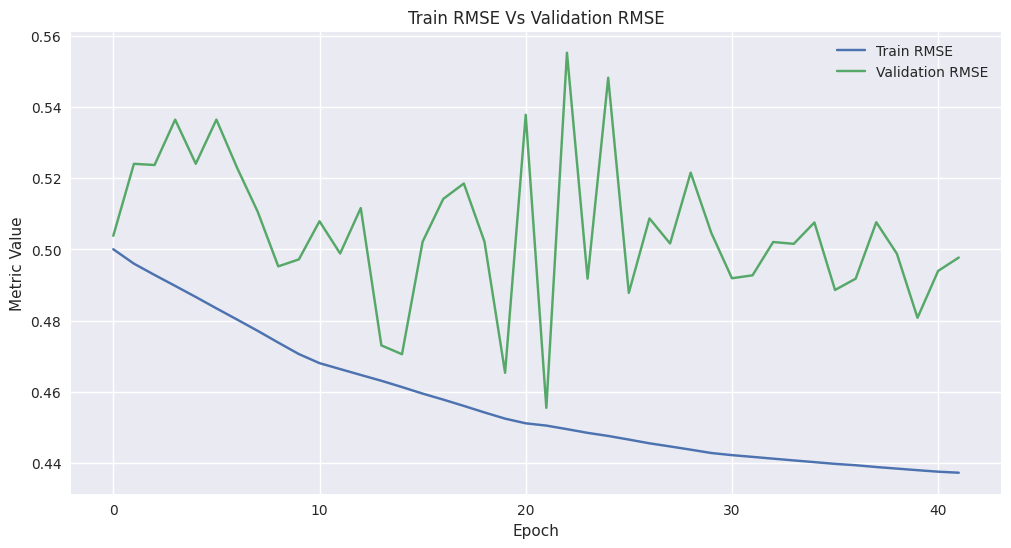

In [63]:
# Plot the train rmse and validation rmse
plt.figure(figsize=(12, 6))
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Train RMSE Vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()


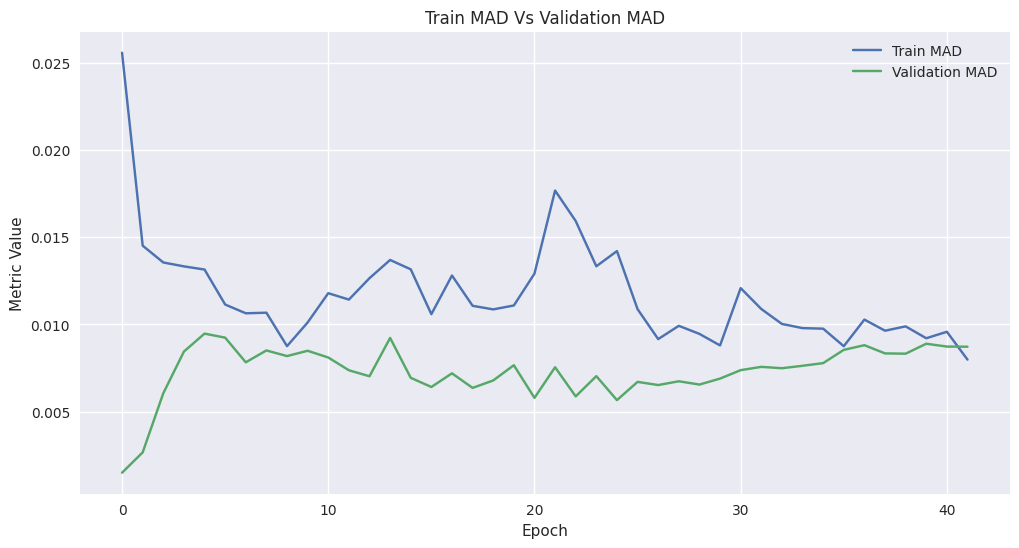

In [64]:
# Plot the tain MAD and validation MAD
plt.figure(figsize=(12, 6))
plt.plot(history.history['mad'], label='Train MAD')
plt.plot(history.history['val_mad'], label='Validation MAD')
plt.title('Train MAD Vs Validation MAD')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()



In [65]:
model.save('CNN3d(E03).h5')

In [66]:
import os
import cv2
import numpy as np

# Function to save all split videos from the test set to a folder
def save_all_split_videos(video_data, save_dir, SEQUENCE_LENGTH=30, IMAGE_HEIGHT=128, IMAGE_WIDTH=128, fps=30):
    """
    Save all split videos from the video data as individual video files in the specified directory.

    Args:
        video_data: Numpy array containing video data of shape (num_videos, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3).
        save_dir: Directory to save the videos.
        SEQUENCE_LENGTH: Number of frames per video (default is 16).
        IMAGE_HEIGHT: Height of the frames (default is 64).
        IMAGE_WIDTH: Width of the frames (default is 64).
        fps: Frames per second for the output videos (default is 30).
    """
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Iterate over all videos in the dataset
    for video_index in range(video_data.shape[0]):
        video_frames = video_data[video_index]  # Shape: (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

        # Prepare the VideoWriter object to save the video
        video_filename = os.path.join(save_dir, f"split_video_{video_index + 1}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for .mp4 format
        video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Add frames to the video
        for frame in video_frames:
            # Ensure the frame has values in the range [0, 255] and convert to uint8
            frame_rgb = (frame * 255).astype(np.uint8)
            # Convert RGB to BGR for OpenCV
            frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
            # Write the frame to the video
            video_writer.write(frame_bgr)

        # Release the video writer
        video_writer.release()
        print(f"Video {video_index + 1} saved to: {video_filename}")

# Example usage: Save all split videos from the test set
# Make sure `features_test` is defined before calling this function
save_all_split_videos(features_test, save_dir="/kaggle/working/split_videos")


Video 1 saved to: /kaggle/working/split_videos/split_video_1.mp4
Video 2 saved to: /kaggle/working/split_videos/split_video_2.mp4
Video 3 saved to: /kaggle/working/split_videos/split_video_3.mp4
Video 4 saved to: /kaggle/working/split_videos/split_video_4.mp4
Video 5 saved to: /kaggle/working/split_videos/split_video_5.mp4
Video 6 saved to: /kaggle/working/split_videos/split_video_6.mp4
Video 7 saved to: /kaggle/working/split_videos/split_video_7.mp4
Video 8 saved to: /kaggle/working/split_videos/split_video_8.mp4
Video 9 saved to: /kaggle/working/split_videos/split_video_9.mp4
Video 10 saved to: /kaggle/working/split_videos/split_video_10.mp4
Video 11 saved to: /kaggle/working/split_videos/split_video_11.mp4
Video 12 saved to: /kaggle/working/split_videos/split_video_12.mp4
Video 13 saved to: /kaggle/working/split_videos/split_video_13.mp4
Video 14 saved to: /kaggle/working/split_videos/split_video_14.mp4
Video 15 saved to: /kaggle/working/split_videos/split_video_15.mp4
Video 16 save

In [67]:
import cv2
import numpy as np

# Constants (update according to your model configuration)
SEQUENCE_LENGTH = 30  # Model expects 30 frames per video
IMAGE_HEIGHT = 128    # Model expects 128x128 resolution
IMAGE_WIDTH = 128

def process_video(video_path):
    """
    Preprocess a video for 3D-CNN model inference.
    Args:
        video_path (str): Path to the video file.
    Returns:
        np.ndarray: Preprocessed video data with shape (1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Read and preprocess frames
    while len(frames) < SEQUENCE_LENGTH:
        ret, frame = cap.read()
        if not ret:
            break
        # Resize frame to match model's expected input size
        frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        frame = frame / 255.0  # Normalize pixel values to [0, 1]
        frames.append(frame)

    cap.release()

    # Handle cases where video has fewer frames than SEQUENCE_LENGTH
    while len(frames) < SEQUENCE_LENGTH:
        frames.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3)))  # Pad with black frames

    # Convert to numpy array and add batch dimension
    video_data = np.array(frames[:SEQUENCE_LENGTH])  # Ensure exactly SEQUENCE_LENGTH frames
    return np.expand_dims(video_data, axis=0)  # Shape becomes (1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# Predict for a new video
video_path = '/kaggle/input/test-regre/test_regre/E03_P60_AF_VLL_GF.mp4'

video_data = process_video(video_path)
print(f"Video data shape: {video_data.shape}")  # Should output (1, 30, 128, 128, 3)

predicted_score = model.predict(video_data)
scaled_score = predicted_score * 99 + 1
print(f"Predicted Score: {scaled_score[0][0]:.2f}")  # Assuming `predicted_score` is a 2D array


Video data shape: (1, 30, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Predicted Score: 45.19
